In [ ]:
from google.colab import drive
drive.mount('/drive')
import warnings
warnings.filterwarnings("ignore")

Mounted at /drive


## Library

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from keras.layers import Conv2D, MaxPool2D, Dropout
from keras.layers import Dense, Flatten
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import uniform
from sklearn.svm import SVC
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

## Read Data

In [ ]:
def read_data(location):
  '''
  Read data from the corresponding .csv file and return the labels and features data.
  Location: The file's path.
  '''
  vectors_csv = pd.read_csv(location)
  vectors = vectors_csv.to_numpy()
  labels = vectors[:, 0].astype(int) # Read labels.
  vectors_data = vectors[:, 1:] # Read data except labels.

  return vectors_data, labels

## Plot the Images

In [ ]:
def plot_images(vectors, plot_num, image_size=28):
  '''
  Plot the vectors as images.
  Vectors: Raw input data.
  Depth: The number
  '''
  SIZE = image_size # The size of square images.
  PLOT_SIZE = plot_num # The number of images to be plotted.
  
  images_data = np.zeros((PLOT_SIZE, SIZE, SIZE), dtype=float) # Ndarrays to contain images data.
  for k in range(images_data.shape[0]):
    for i in range(SIZE):
      for j in range(SIZE):
        images_data[k, i, j] = vectors[k, i * SIZE + j]  # Convert vectors to square matrices.

  for i in range(PLOT_SIZE):
    plt.imshow(images_data[i])
    print(labels[i])
    plt.show()

## Process Nan Values

In [ ]:
def Nan_process(vectors_data, labels, method=0, SIZE=28):
  '''
  Check all the images if they contain Nan values inside and plot them if they have
  nan values. If method=0, then delete the image if the proportion of Nan values 
  is higher than 0.5. If method=1, replace all the Nan values with 0. Else, replace
  all the Nan values with padding.
  Vectors_data: Feature data that may contain Nan values.
  Method: Method of processing Nan values.
  '''

  data = vectors_data.copy()
  truth = labels.copy()
  
  # Delete the image whose proportion of Nan values is higher than 0.5.
  if method==0:
    indices = [] # Contain all the indices of images containing Nan values.
    proportions = [] # The proportion of Nan values in a single image.
    deleted = [] # The indices of images deleted from the original dataset.

    for i in range(data.shape[0]):
      if np.isnan(data[i].sum()): # Judge if an image contains Nan values.
        indices.append(i)

    for i in indices:
      proportion = np.isnan(data[i]).sum()/data[i].size # Calculation of the Nan values in an image.
      proportions.append(proportion)
      if proportion > 0.5:
        data = np.delete(data, indices, 0)
        truth = np.delete(truth, indices)
        deleted.append(i)

    print('The images including \'Nan\' values are ' + str(indices))
    print('The proportion of \'Nan\' values in each images are ' +str(proportions))
    print('The indices of deleted images are ' +str(deleted))

    # Plot the images containing Nan values.
    num = len(indices)
    images_data = np.zeros((num, SIZE, SIZE), dtype=float) # Ndarrays to contain images data.
    for k, index in enumerate(indices):
      for i in range(SIZE):
        for j in range(SIZE):
          images_data[k, i, j] = vectors_data[index, i * SIZE + j]  # Convert vectors to square matrices.

    for i in range(num):
      print('\n Images with missing values are plotted as following:')
      plt.imshow(images_data[i])
      plt.show()

  # Replace all the Nan values with 0.
  else:
    data = np.nan_to_num(data, nan=0)

  return data, truth

## Scaling the Data

In [ ]:
def Scale(data, method, threshold=0, pca_valid=0, pca_dim=0):
  '''
  Different ways to process data values. 
  Method=0: Change all values greater than the threshold to 1 and others to 0.
  Method=1: Normalise the data.
  Pca_valid: To control whether PCA will be used when processing the data.
  Pca_dim: The dimensions of the features.
  '''

  if method==0:
    scaled_data = (data > threshold) * 1
    plot_images(scaled_data, 5)
  else:
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
  if pca_valid==1: # Choose whether to enable PCA.
    N = pca_dim #number of principal components 
    pca = PCA(n_components=N) # Initialize PCA
    scaled_data = pca.fit_transform(scaled_data) # feature extraction
  return scaled_data

## Data Split

In [ ]:
def split(features, labels, test_size):
  x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=4720)
  return x_train, x_test, y_train, y_test

## Training & Test Method

In [ ]:
def train(x_train, y_train, model, parameters, one_hot=0, batch_size=128, epochs=60):
  '''
  Train and return the model, giving the information about the validation error and accuracy.
  The labels can be switched into one_hot encoding according to the requirements.
  One_hot: When One hot == 1, the labels are changed to one_hot encoded mode.
  '''

  # Whether the model is a neural network.
  if isinstance(model, Sequential):
    x_train = x_train.reshape((-1, 28, 28, 1)) # Reshape the input data according to the neural network.
    y_train = to_categorical(y_train, 10)
  else:
    # model = GridSearchCV(model, parameters, n_jobs=-1, cv=2, verbose=1)
    model = RandomizedSearchCV(model, parameters, n_jobs=-1, cv=5, verbose=1)
    if one_hot == 1:
      y_train = to_categorical(y_train, 10)

  if isinstance(model, Sequential):
    model.fit(x_train, y_train, batch_size, epochs)

  else:
    if one_hot == 1: # If the output is set to one_hot encoded.
      model = MultiOutputClassifier(model).fit(x_train, y_train) # The classifier should support multi output if it uses one_hot encoding.
    else:
      model.fit(x_train, y_train)

  return model

In [ ]:
def test(x_test, y_test, model, one_hot=0):
  '''
  Test the model with test dataset. The parameter one_hot should be identical to
  the one in the train function.
  '''

  if isinstance(model, Sequential):
    x_tset = x_test.reshape((-1, 28, 28, 1))
    y_test = to_categorical(y_test, 10)
  else:
    if one_hot == 1:
      y_test = to_categorical(y_test, 10)

  if isinstance(model, Sequential):
    probability = model.predict(x_test) # The real predicted result is the label with the largest probability.
    y_test = np.argmax(y_test, axis=1)
    y_pre = np.argmax(probability, axis=1)

  else:
    if one_hot == 1:
      predictions = model.predict(x_test)
      y_test = np.argmax(y_test, axis=1)
      y_pre = np.argmax(predictions, axis=1)
    else:
      y_pre = model.predict(x_test)
      confusion_matrix(y_test, y_pre)
      plot_confusion_matrix(model, x_test, y_test)

  acc = accuracy_score(y_test, y_pre)
  print('The test accuracy is: ' + str(acc))
  return acc # Accuracy is returned for plotting graphs.

## Models

In [ ]:
model1 = LogisticRegression(n_jobs=-1)

In [ ]:
model2 = RandomForestClassifier(oob_score=True, random_state=4720, n_estimators=200)

In [ ]:
model3 = lgb.LGBMClassifier(learning_rate=0.2, max_depth=15, num_estimators=200)

In [ ]:
model4 = KNeighborsClassifier(n_neighbors=10)

In [ ]:
model5 = SVC(gamma='auto')

In [ ]:
# Neural network using CNN.
model_neural = Sequential()
model_neural.add(Conv2D(32, kernel_size=(5,5), activation='relu', input_shape=(28, 28, 1)))
model_neural.add(Conv2D(32, kernel_size=(5,5), activation='relu'))
model_neural.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_neural.add(Dropout(0.25)) # Regularisation using dropout.
model_neural.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model_neural.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model_neural.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_neural.add(Dropout(0.25))
model_neural.add(Flatten())
model_neural.add(Dense(256, activation='relu'))
model_neural.add(Dense(10, activation='softmax'))
model_neural.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Grid Search

2


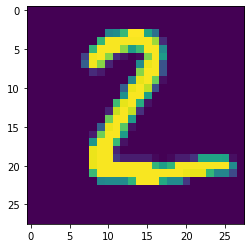

1


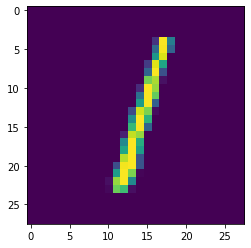

0


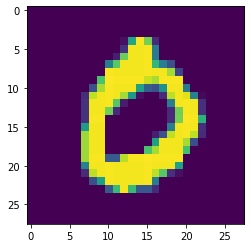

4


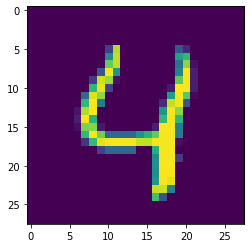

1


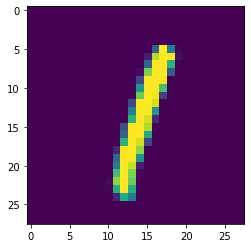

The images including 'Nan' values are [8041]
The proportion of 'Nan' values in each images are [0.5216836734693877]
The indices of deleted images are [8041]

 Images with missing values are plotted as following:


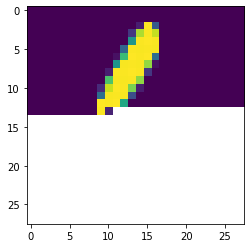

2


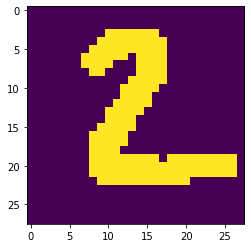

1


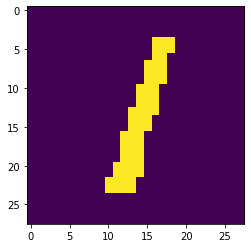

0


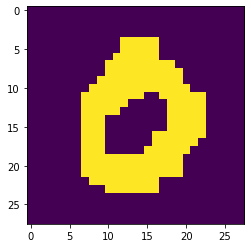

4


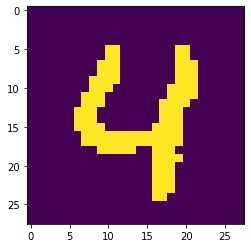

1


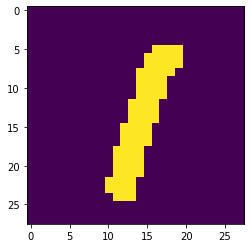

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best parameters set for the model is{'gamma': 0.001, 'C': 100000.0}
The test accuracy is: 0.9627097576134245


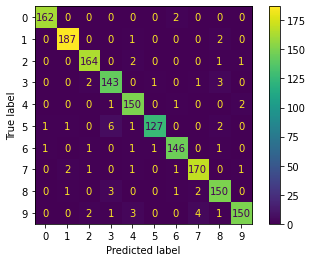

In [ ]:
LARGE = 0

# Parameters that are going to be searched during the random search.
parameters_model1 = {'penalty':['l1', 'l2', 'none', 'elasticnet'], 'C':uniform(loc=5, scale=30), 'multi_class':['ovr', 'multinomial']} # for random search
parameters_model2 = {'n_estimators':np.arange(50, 300),'criterion':['gini', 'entropy'],'bootstrap':[True,False]}
parameters_model3 = {'num_leaves':np.arange(10, 100),'n_estimators':np.arange(50, 300),'max_depth':np.arange(30, 50)}
parameters_model4 = {'n_neighbors':np.arange(1, 10), 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'p': [1, 2]}
parameters_model5 = {'gamma':np.logspace(-9, 3, 13), 'C':np.logspace(-2, 10, 13)}

if LARGE == 0: # Decide to use Number.csv or MINIST from Keras Library
  vectors_data, labels = read_data('/drive/My Drive/ML/Project/Numbers.csv')
  plot_images(vectors_data, 5)
  vectors_data_dl, labels_dl = Nan_process(vectors_data, labels, method=0)

  # The codes in the notation part is used to tune the hyper-parameter in PCA.

  # acc_list = []
  # pca_search = np.arange(20, 80)
  # for n in pca_search:
  vectors_data_s = Scale(vectors_data_dl, method=0, pca_valid=1, pca_dim=43)
  x_train, x_test, y_train, y_test = split(vectors_data_s, labels_dl, 0.2)

  model = train(x_train, y_train, model5, parameters_model5, one_hot=0)
  print('The best parameters set for the model is' + str(model.best_params_))
  acc = test(x_test, y_test, model, one_hot=0)
  # acc_list.append(acc)

else:
  from keras.datasets import mnist
  data = mnist.load_data()
  data_np = np.array(data)
  vectors_data = np.concatenate((data_np[0, 0], data_np[1, 0]), axis=0)
  vectors_data = vectors_data.reshape(vectors_data.shape[0], -1)
  labels = np.concatenate((data_np[0, 1], data_np[1, 1]), axis=0)
  labels = labels.reshape(labels.shape[0], -1)
  plot_images(vectors_data, 5)
  vectors_data_dl, labels_dl = Nan_process(vectors_data, labels, method=0)

  # acc_list = []
  # pca_search = np.arange(20, 80)
  # for n in pca_search:
  vectors_data_s = Scale(vectors_data_dl, method=0, pca_valid=1, pca_dim=43)
  x_train, x_test, y_train, y_test = split(vectors_data_s, labels_dl, 0.2)

  model = train(x_train, y_train, model5, parameters_model5, one_hot=0)
  print('The best parameters set for the model is' + str(model.best_params_))
  # acc = test(x_test, y_test, model, one_hot=0)
  # acc_list.append(acc)

## PCA Search Plot

In [ ]:
# acc_list = np.array(acc_list)
# x = pca_search
# y = acc_list

# fig, ax = plt.subplots(figsize=(8, 6)) # fig is the big Figure, ax is the subfigure in it
# ax.plot(x, y, linewidth=1.5, color='orange', label='Accuracy')
# ax.set(xticks=np.arange(20, 80, 5))
# ax.set_xlabel('PCA dimension')
# ax.set_ylabel('Test Accuracy')
# ax.set_title('Accuracy VS PCA Dimensions')
# ax.annotate('Chosen Point: (' + str(pca_search[np.argmax(acc_list)]) + ', '+ str(max(acc_list)) + ')', 
#             xy=(pca_search[np.argmax(acc_list)], max(acc_list)),  
#             xycoords='data', xytext=(0.9, 0.4), textcoords='axes fraction',
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             horizontalalignment='right', verticalalignment='top',
#             )
# ax.legend()

# plt.show()
